In [1]:
import torch
from torch import nn
import numpy as np
import sys
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import importlib

sys.path.append("..")
from model import ParticleEventTransformer
from data import get_database_path, get_h5_files, read_h5_file, select_events
from utils import load_toml_config

import matplotlib.pyplot as plt


device = "cuda" if torch.cuda.is_available() else "mps" if sys.platform == "darwin" else "cpu"
random_seed = 114514
torch.manual_seed(random_seed)
np.random.seed(random_seed)

In [2]:
EMD_config = load_toml_config("EMD")
particle_type_scale = EMD_config['particle_type_scale']

model_hyper_parameters = load_toml_config("Transformer")
output_dim = model_hyper_parameters["output_dim"]

# Load embedding points

In [3]:
import h5py
embedding_points = h5py.File("../embedding_points.h5", "r")
for key in embedding_points.keys():
    print(embedding_points[key].shape)

(13451915, 4)
(760272, 4)
(340544, 4)
(691283, 4)
(55969, 4)


In [4]:
from analysis import Normalizer
normalizer = Normalizer(*[value for value in embedding_points.values()])

In [5]:
print(normalizer.max)
print(normalizer.min)

[369.1842041  370.31808472 327.48770142 326.72790527]
[-377.18408203 -356.34307861 -320.93734741 -340.06167603]


# Split embed points

In [6]:
tpr_dict = {}
fpr_dict = {}
auc_dict = {}

In [7]:
from analysis import create_exp_bkg_events, train_test_split, get_dataloaders

In [8]:
test_ratio=0.2
val_ratio = 0.2
sig_lambda = 0.5
n = 200000

# test_signal = "neutral_boson"
test_signal = "leptoquark"
# test_signal = "neutral_Higgs"
# test_signal = "charged_Higgs"

exp_events, bkg_events = np.array(embedding_points['SM'])[:len(np.array(embedding_points[test_signal]))], np.array(embedding_points[test_signal])
X1, X2, W1, W2 = train_test_split(exp_events, bkg_events, test_ratio)
n1 = len(W1)
m1 = len(X1)
pi = n1 / (n1 + m1)
n2 = len(W2)
m2 = len(X2)
train_dataloader, val_dataloader = get_dataloaders(X1, W1, val_ratio, normalizer, train_batch_size=1000, val_batch_size=1000)

# Classify Model

In [9]:
from model import MLP
hidden_dim = [8, 16, 16, 16, 8]
naive_model = MLP(output_dim, hidden_sizes=hidden_dim)

# Train

In [10]:
from metrics import BinaryACCUpdater

In [11]:
naive_model.to(device)
optimizer = torch.optim.Adam(naive_model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.BCELoss()
acc_metric = BinaryACCUpdater()
metric_dict = {"Accuracy": acc_metric}

In [12]:
from classify import train_model

In [13]:
# opt_train_model  = torch.compile(train_model)

In [14]:
train_model(
    naive_model, optimizer,
    loss_fn, metrics_dict=metric_dict,
    train_dataloader=train_dataloader, val_dataloader=val_dataloader,
    monitor="val_Accuracy", mode="max",
    epochs=50
    )


================================================================================2024-07-11 20:47:59
Epoch 1 / 50

100%|██████████| 109/109 [00:00<00:00, 496.39it/s, val_Accuracy=0.778, val_loss=0.476]
<<<<<< reach best val_Accuracy : 0.778323233127594 >>>>>>

================================================================================2024-07-11 20:48:01
Epoch 2 / 50

100%|██████████| 109/109 [00:00<00:00, 516.05it/s, val_Accuracy=0.785, val_loss=0.463]
<<<<<< reach best val_Accuracy : 0.7847890257835388 >>>>>>

================================================================================2024-07-11 20:48:03
Epoch 3 / 50

100%|██████████| 109/109 [00:00<00:00, 526.95it/s, val_Accuracy=0.789, val_loss=0.456]
<<<<<< reach best val_Accuracy : 0.7885276675224304 >>>>>>

================================================================================2024-07-11 20:48:06
Epoch 4 / 50

100%|██████████| 109/109 [00:00<00:00, 189.63it/s, val_Accuracy=0.79, val_loss=0.453]
<<<<<< reach best

,train_loss,train_Accuracy,val_loss,val_Accuracy,epoch
0,0.557189,0.700116,0.475979,0.778323,1
1,0.467908,0.783314,0.463247,0.784789,2
2,0.459272,0.787676,0.456108,0.788528,3
3,0.454683,0.788944,0.453200,0.789648,4
4,0.452014,0.788993,0.451462,0.789768,5
5,0.449873,0.789153,0.449860,0.789267,6
6,0.449264,0.789121,0.448920,0.790359,7
7,0.448847,0.789170,0.449600,0.789500,8
8,0.448451,0.789196,0.448341,0.790459,9
9,0.448320,0.789450,0.448343,0.790929,10


# ROC

In [22]:
from analysis import predict
targets, predictions = predict(naive_model, val_dataloader)

100%|██████████| 244/244 [00:00<00:00, 484.65it/s]


In [25]:
def plot_roc_curve(fpr_dict, tpr_dict, auc_dict, title):
    for key in fpr_dict.keys():
        fpr = fpr_dict[key]
        tpr = tpr_dict[key]
        auc_roc = auc_dict[key]
        plt.plot(fpr, tpr, label='{} (AUC = {:.2f})'.format(key, auc_roc))
    # plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(auc_roc), lw=2)    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR') 
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

0.9414988659291722


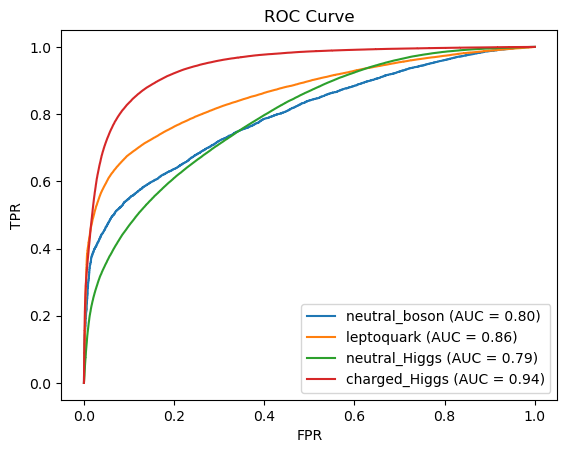

In [26]:
from analysis import calculate_auc
from analysis import ClassifyDataset
fpr, tpr, auc_roc = calculate_auc(targets, predictions)
print(auc_roc)
fpr_dict[str(test_signal)] = fpr
tpr_dict[str(test_signal)] = tpr
auc_dict[str(test_signal)] = auc_roc
plot_roc_curve(fpr_dict, tpr_dict, auc_dict, "ROC Curve")


================================================================================2024-07-11 20:57:40
Epoch 1 / 50

100%|██████████| 18/18 [00:00<00:00, 147.03it/s, val_Accuracy=0.679, val_loss=0.639]
<<<<<< reach best val_Accuracy : 0.6785128712654114 >>>>>>

================================================================================2024-07-11 20:57:41
Epoch 2 / 50

100%|██████████| 18/18 [00:00<00:00, 169.53it/s, val_Accuracy=0.693, val_loss=0.606]
<<<<<< reach best val_Accuracy : 0.6927601099014282 >>>>>>

================================================================================2024-07-11 20:57:42
Epoch 3 / 50

100%|██████████| 18/18 [00:00<00:00, 168.44it/s, val_Accuracy=0.701, val_loss=0.563]
<<<<<< reach best val_Accuracy : 0.700657069683075 >>>>>>

================================================================================2024-07-11 20:57:43
Epoch 4 / 50

100%|██████████| 18/18 [00:00<00:00, 180.41it/s, val_Accuracy=0.716, val_loss=0.543]
<<<<<< reach best val_Ac

100%|██████████| 23/23 [00:00<00:00, 102.21it/s]



================================================================================2024-07-11 20:58:03
Epoch 1 / 50

100%|██████████| 109/109 [00:00<00:00, 539.15it/s, val_Accuracy=0.786, val_loss=0.463]
<<<<<< reach best val_Accuracy : 0.7855299711227417 >>>>>>

================================================================================2024-07-11 20:58:04
Epoch 2 / 50

100%|██████████| 109/109 [00:00<00:00, 558.87it/s, val_Accuracy=0.787, val_loss=0.458]
<<<<<< reach best val_Accuracy : 0.7872747182846069 >>>>>>

================================================================================2024-07-11 20:58:06
Epoch 3 / 50

100%|██████████| 109/109 [00:00<00:00, 551.51it/s, val_Accuracy=0.789, val_loss=0.454]
<<<<<< reach best val_Accuracy : 0.7887016534805298 >>>>>>

================================================================================2024-07-11 20:58:08
Epoch 4 / 50

100%|██████████| 109/109 [00:00<00:00, 528.04it/s, val_Accuracy=0.79, val_loss=0.452]
<<<<<< reach bes

100%|██████████| 137/137 [00:00<00:00, 249.71it/s]



================================================================================2024-07-11 20:58:34
Epoch 1 / 50

100%|██████████| 222/222 [00:00<00:00, 688.41it/s, val_Accuracy=0.67, val_loss=0.582]
<<<<<< reach best val_Accuracy : 0.6695112586021423 >>>>>>

================================================================================2024-07-11 20:58:37
Epoch 2 / 50

100%|██████████| 222/222 [00:00<00:00, 687.90it/s, val_Accuracy=0.687, val_loss=0.566]
<<<<<< reach best val_Accuracy : 0.6871519684791565 >>>>>>

================================================================================2024-07-11 20:58:40
Epoch 3 / 50

100%|██████████| 222/222 [00:00<00:00, 656.96it/s, val_Accuracy=0.695, val_loss=0.556]
<<<<<< reach best val_Accuracy : 0.6945803761482239 >>>>>>

================================================================================2024-07-11 20:58:43
Epoch 4 / 50

100%|██████████| 222/222 [00:00<00:00, 701.42it/s, val_Accuracy=0.695, val_loss=0.555]
<<<<<< reach bes

100%|██████████| 277/277 [00:00<00:00, 292.14it/s]



================================================================================2024-07-11 21:00:25
Epoch 1 / 50

100%|██████████| 244/244 [00:00<00:00, 695.78it/s, val_Accuracy=0.862, val_loss=0.334]
<<<<<< reach best val_Accuracy : 0.8623501658439636 >>>>>>

================================================================================2024-07-11 21:00:29
Epoch 2 / 50

100%|██████████| 244/244 [00:00<00:00, 643.05it/s, val_Accuracy=0.864, val_loss=0.327]
<<<<<< reach best val_Accuracy : 0.8635911345481873 >>>>>>

================================================================================2024-07-11 21:00:33
Epoch 3 / 50

100%|██████████| 244/244 [00:00<00:00, 671.13it/s, val_Accuracy=0.864, val_loss=0.323]
<<<<<< reach best val_Accuracy : 0.8642143607139587 >>>>>>

================================================================================2024-07-11 21:00:36
Epoch 4 / 50

100%|██████████| 244/244 [00:00<00:00, 672.90it/s, val_Accuracy=0.865, val_loss=0.321]
<<<<<< reach be

100%|██████████| 305/305 [00:00<00:00, 306.71it/s]


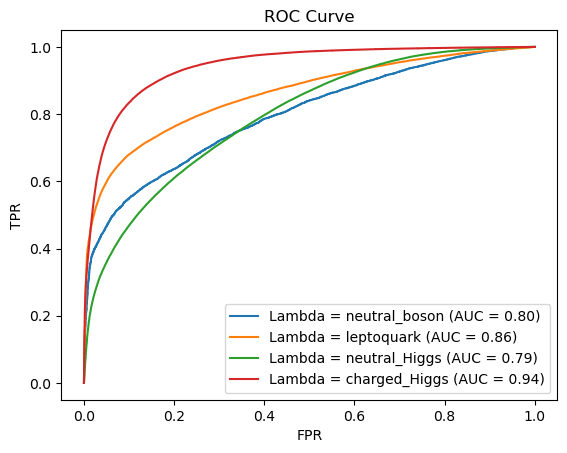

In [24]:
test_signals = ["neutral_boson", "leptoquark", "neutral_Higgs", "charged_Higgs"]
tpr_dict = {}
fpr_dict = {}
auc_dict = {}
for test_signal in test_signals:
    exp_events, bkg_events = np.array(embedding_points['SM'])[np.random.choice(len(np.array(embedding_points['SM'])), len(np.array(embedding_points[test_signal])), replace=False)], np.array(embedding_points[test_signal])
    X1, X2, W1, W2 = train_test_split(exp_events, bkg_events, test_ratio)
    n1 = len(W1)
    m1 = len(X1)
    pi = n1 / (n1 + m1)
    n2 = len(W2)
    m2 = len(X2)
    train_dataloader, val_dataloader = get_dataloaders(X1, W1, val_ratio, normalizer, train_batch_size=1000, val_batch_size=1000)

    hidden_dim = [8, 16, 16, 16, 8]
    naive_model = MLP(output_dim, hidden_sizes=hidden_dim)

    naive_model.to(device)
    optimizer = torch.optim.Adam(naive_model.parameters(), lr=1e-3, weight_decay=1e-5)
    loss_fn = nn.BCELoss()
    acc_metric = BinaryACCUpdater()
    metric_dict = {"Accuracy": acc_metric}

    train_model(
        naive_model, optimizer,
        loss_fn, metrics_dict=metric_dict,
        train_dataloader=train_dataloader, val_dataloader=val_dataloader,
        monitor="val_Accuracy", mode="max",
        epochs=50
        )
    
    val_dataset = ClassifyDataset(W2, X2, normalizer=normalizer)
    val_dataloader = DataLoader(val_dataset, batch_size=1000)
    targets, predictions = predict(naive_model, val_dataloader)

    fpr, tpr, auc_roc = calculate_auc(targets, predictions)
    fpr_dict[str(test_signal)] = fpr
    tpr_dict[str(test_signal)] = tpr
    auc_dict[str(test_signal)] = auc_roc

plot_roc_curve(fpr_dict, tpr_dict, auc_dict, "ROC Curve")
    